In [1]:
# 1. Проведите эксперименты, постройте график скорости cходимости сети в зависимости от learning_rate, 
# выберите оптимальное значение.

# 2. Примените нормализацию данных. Исследуйте скорость сходимости.

# 3. Измените струтуру сети. Постройте график/таблицу зависимости качества обучения в зависимости от удаления/добавления
# скрытого слоя, Удаления/добавления нейронов в каждом слое.

# 4. Исследуйте скорость сходимости сети в зависимости от выбранной функции активации в слоях.
# https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

# 5. Исследуйте скорость сходимости сети в зависимости от выбранного метода оптимизации.
# https://pytorch.org/docs/stable/optim.html

# 6. Исследуйте скорость сходимости сети в зависимости от начальной инициализации весов.

In [3]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from torch import nn, optim

import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Предсказание погоды на следующий день: 
Будет дождь, если rainfall >=1

In [5]:
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [6]:
df.shape

(145460, 23)

Удалим столбцы

In [11]:
cols = ['Rainfall', 'Humidity3pm', 'Pressure9am', 'RainToday', 'RainTomorrow']

df = df[cols]

Удаление строк с пропущенными значениями

In [14]:
df = df.dropna()
df.head()

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,No,No
1,0.0,25.0,1010.6,No,No
2,0.0,30.0,1007.6,No,No
3,0.0,16.0,1017.6,No,No
4,1.0,33.0,1010.8,No,No


Преобразование данных стобца

In [17]:
df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)

C:\Users\seva0\AppData\Local\Temp\ipykernel_15068\3734455367.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
C:\Users\seva0\AppData\Local\Temp\ipykernel_15068\3734455367.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['RainToday

In [19]:
df[df['RainTomorrow']==0.0].count()

Rainfall        97103
Humidity3pm     97103
Pressure9am     97103
RainToday       97103
RainTomorrow    97103
dtype: int64

In [21]:
df[df['RainTomorrow']==1.0].count()

Rainfall        27586
Humidity3pm     27586
Pressure9am     27586
RainToday       27586
RainTomorrow    27586
dtype: int64

Классы несбалансированы

In [24]:
X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
y = df[['RainTomorrow']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

Преобразуем в тензор

In [27]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([99751, 4]) torch.Size([99751])
torch.Size([24938, 4]) torch.Size([24938])


#NN

In [30]:

class Net(nn.Module):

  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 8)
    self.fc2 = nn.Linear(8, 4)
    self.fc3 = nn.Linear(4, 1)
    
    # torch.nn.init.xavier_uniform_(self.fc1.weight) 

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

In [32]:
criterion = nn.BCELoss()

In [34]:
device = torch.device( "cpu")

In [36]:
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

In [38]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

In [40]:
net = Net(4)
optimizer = optim.Adam(net.parameters(), lr=0.0001)
net = net.to(device)

criterion = criterion.to(device)

for epoch in range(2000):

    train_loss = 0
    y_pred = net(X_train)
    
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
        
    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    if epoch % 100 == 0:

          y_test_pred = net(X_test)
          y_test_pred = torch.squeeze(y_test_pred)

          test_loss = criterion(y_test_pred, y_test)

          test_acc = calculate_accuracy(y_test, y_test_pred)
          print(
    f'''epoch {epoch}
    Test  set - loss: {test_loss}, accuracy: {test_acc}
    ''')

epoch 0
    Test  set - loss: 7.164628505706787, accuracy: 0.2216697335243225
    
epoch 100
    Test  set - loss: 0.5720796585083008, accuracy: 0.796014130115509
    
epoch 200
    Test  set - loss: 0.5436038970947266, accuracy: 0.7788916230201721
    
epoch 300
    Test  set - loss: 0.5333546996116638, accuracy: 0.7793327569961548
    
epoch 400
    Test  set - loss: 0.5154785513877869, accuracy: 0.7796936631202698
    
epoch 500
    Test  set - loss: 0.480743408203125, accuracy: 0.7794530391693115
    
epoch 600
    Test  set - loss: 0.4678124487400055, accuracy: 0.7808966040611267
    
epoch 700
    Test  set - loss: 0.4557696580886841, accuracy: 0.784866452217102
    
epoch 800
    Test  set - loss: 0.44445258378982544, accuracy: 0.7911219596862793
    
epoch 900
    Test  set - loss: 0.4336603879928589, accuracy: 0.7984601855278015
    
epoch 1000
    Test  set - loss: 0.424217164516449, accuracy: 0.8103296160697937
    
epoch 1100
    Test  set - loss: 0.41721048951148987, accur

In [41]:
MODEL_PATH = 'model.pth'

torch.save(net, MODEL_PATH)

In [42]:
net = torch.load(MODEL_PATH)

C:\Users\seva0\AppData\Local\Temp\ipykernel_15068\804352145.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(MODEL_PATH)


In [51]:
classes = ['No rain', 'Raining']

y_pred = net(X_test)

y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.85      0.96      0.90     19413
     Raining       0.74      0.40      0.52      5525

    accuracy                           0.84     24938
   macro avg       0.79      0.68      0.71     24938
weighted avg       0.82      0.84      0.82     24938



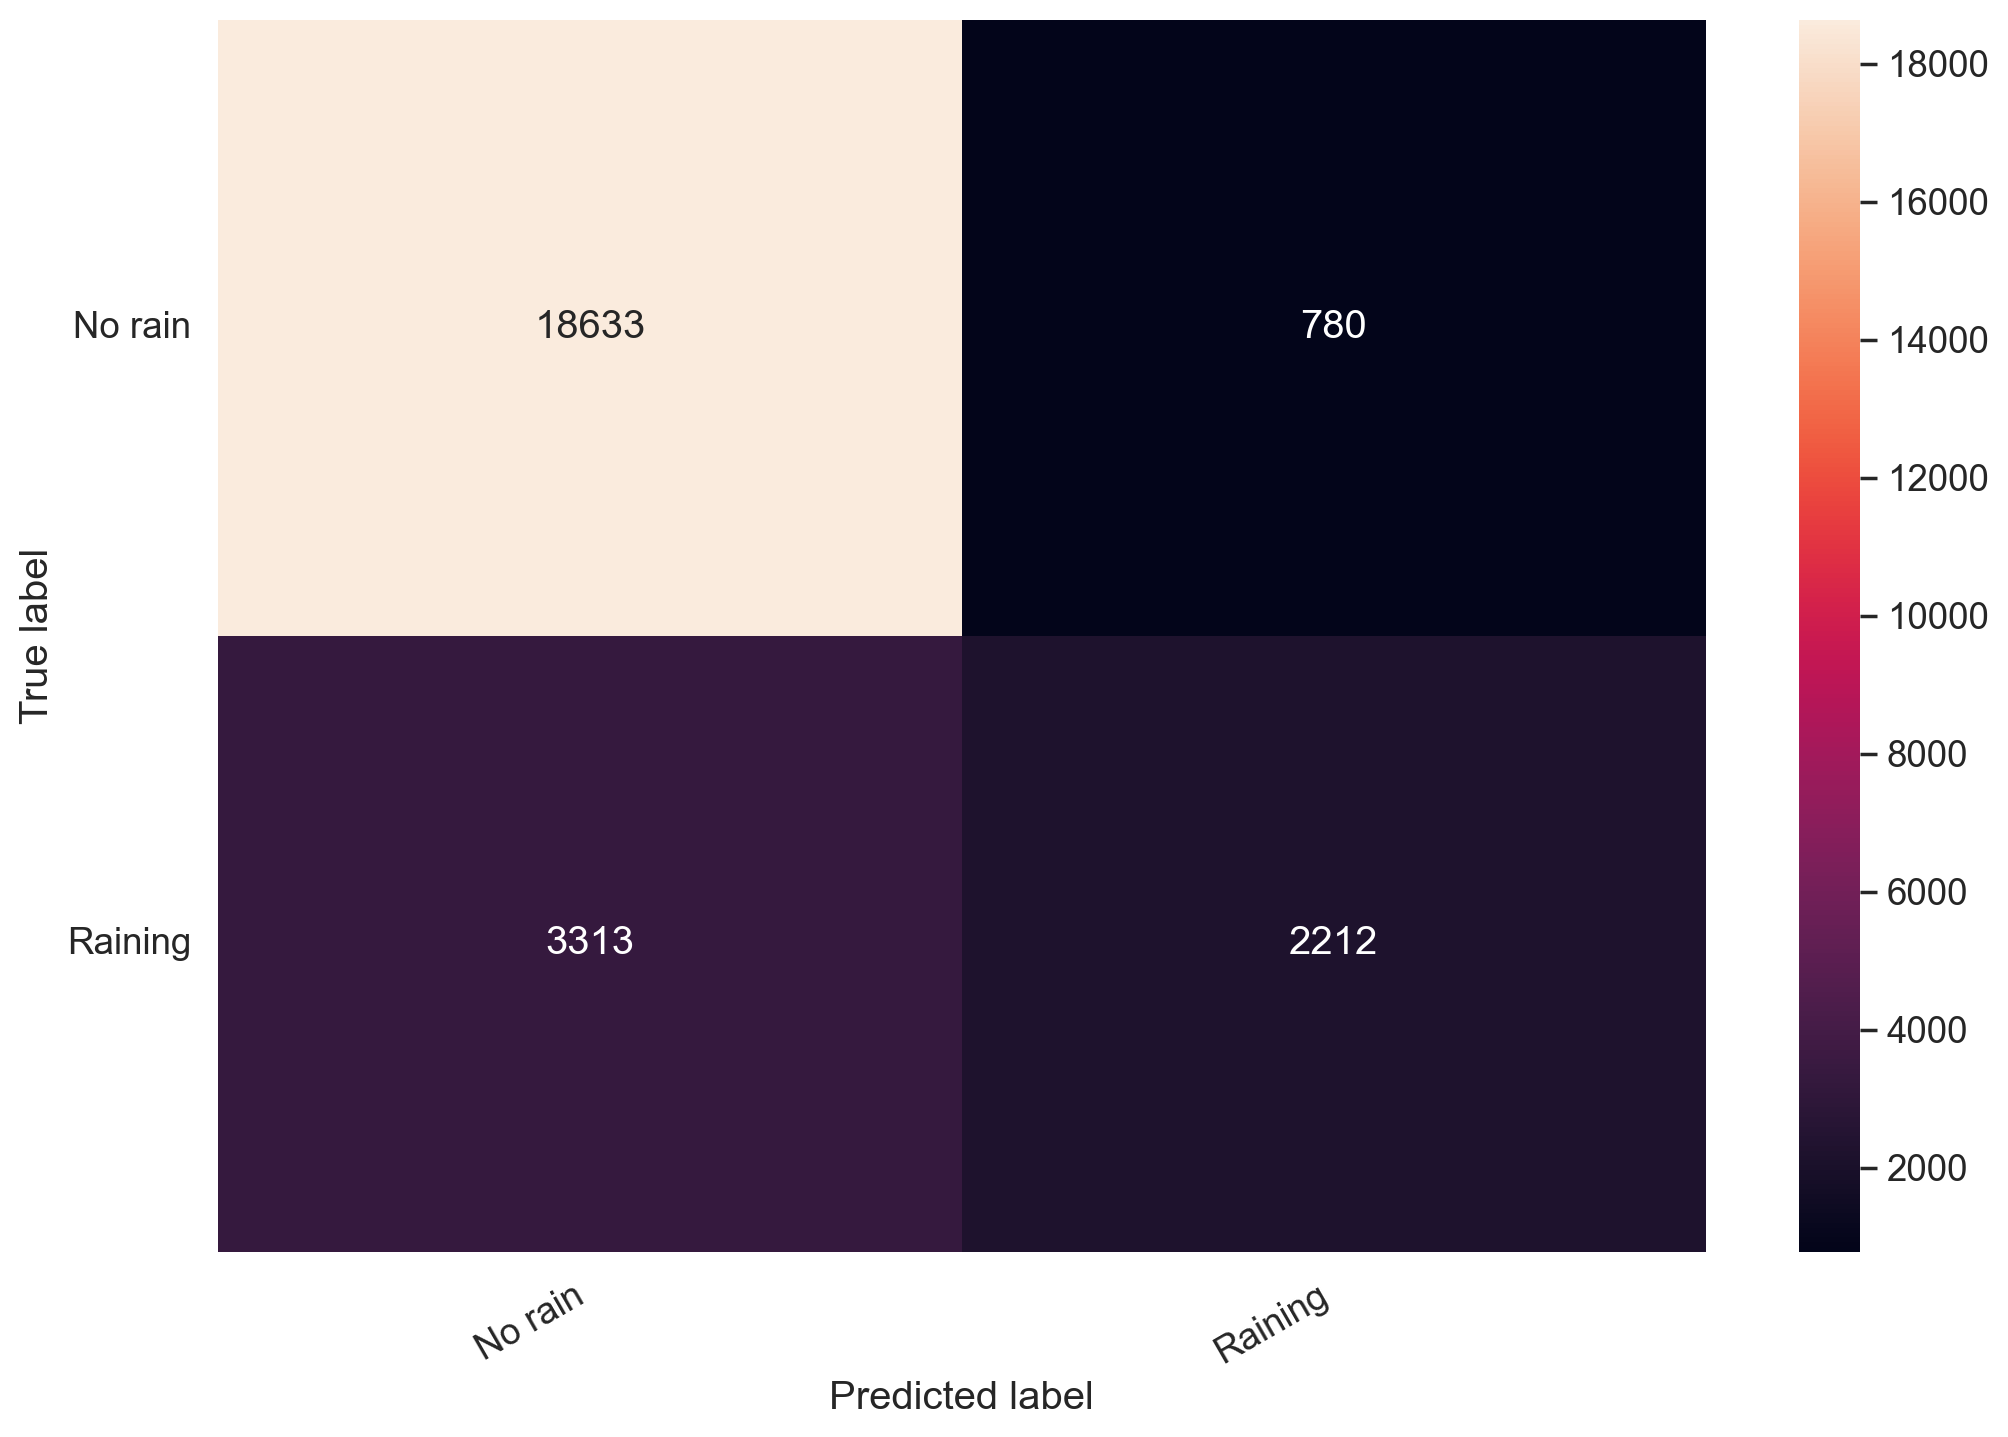

In [52]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

Learning Rate: 0.00100, Epoch: 0, Test Loss: 77.8451, Test Accuracy: 0.2215
Learning Rate: 0.00100, Epoch: 100, Test Loss: 77.8451, Test Accuracy: 0.2215
Learning Rate: 0.00100, Epoch: 200, Test Loss: 77.8451, Test Accuracy: 0.2215
Learning Rate: 0.00100, Epoch: 300, Test Loss: 77.8451, Test Accuracy: 0.2215
Learning Rate: 0.00100, Epoch: 400, Test Loss: 77.8451, Test Accuracy: 0.2215
Learning Rate: 0.00100, Epoch: 500, Test Loss: 77.8451, Test Accuracy: 0.2215
Learning Rate: 0.00100, Epoch: 600, Test Loss: 77.8451, Test Accuracy: 0.2215
Learning Rate: 0.00100, Epoch: 700, Test Loss: 77.8451, Test Accuracy: 0.2215
Learning Rate: 0.00100, Epoch: 800, Test Loss: 77.8451, Test Accuracy: 0.2215
Learning Rate: 0.00100, Epoch: 900, Test Loss: 77.8451, Test Accuracy: 0.2215
Learning Rate: 0.00100, Epoch: 1000, Test Loss: 77.8451, Test Accuracy: 0.2215
Learning Rate: 0.00100, Epoch: 1100, Test Loss: 77.8451, Test Accuracy: 0.2215
Learning Rate: 0.00100, Epoch: 1200, Test Loss: 77.8451, Test Ac

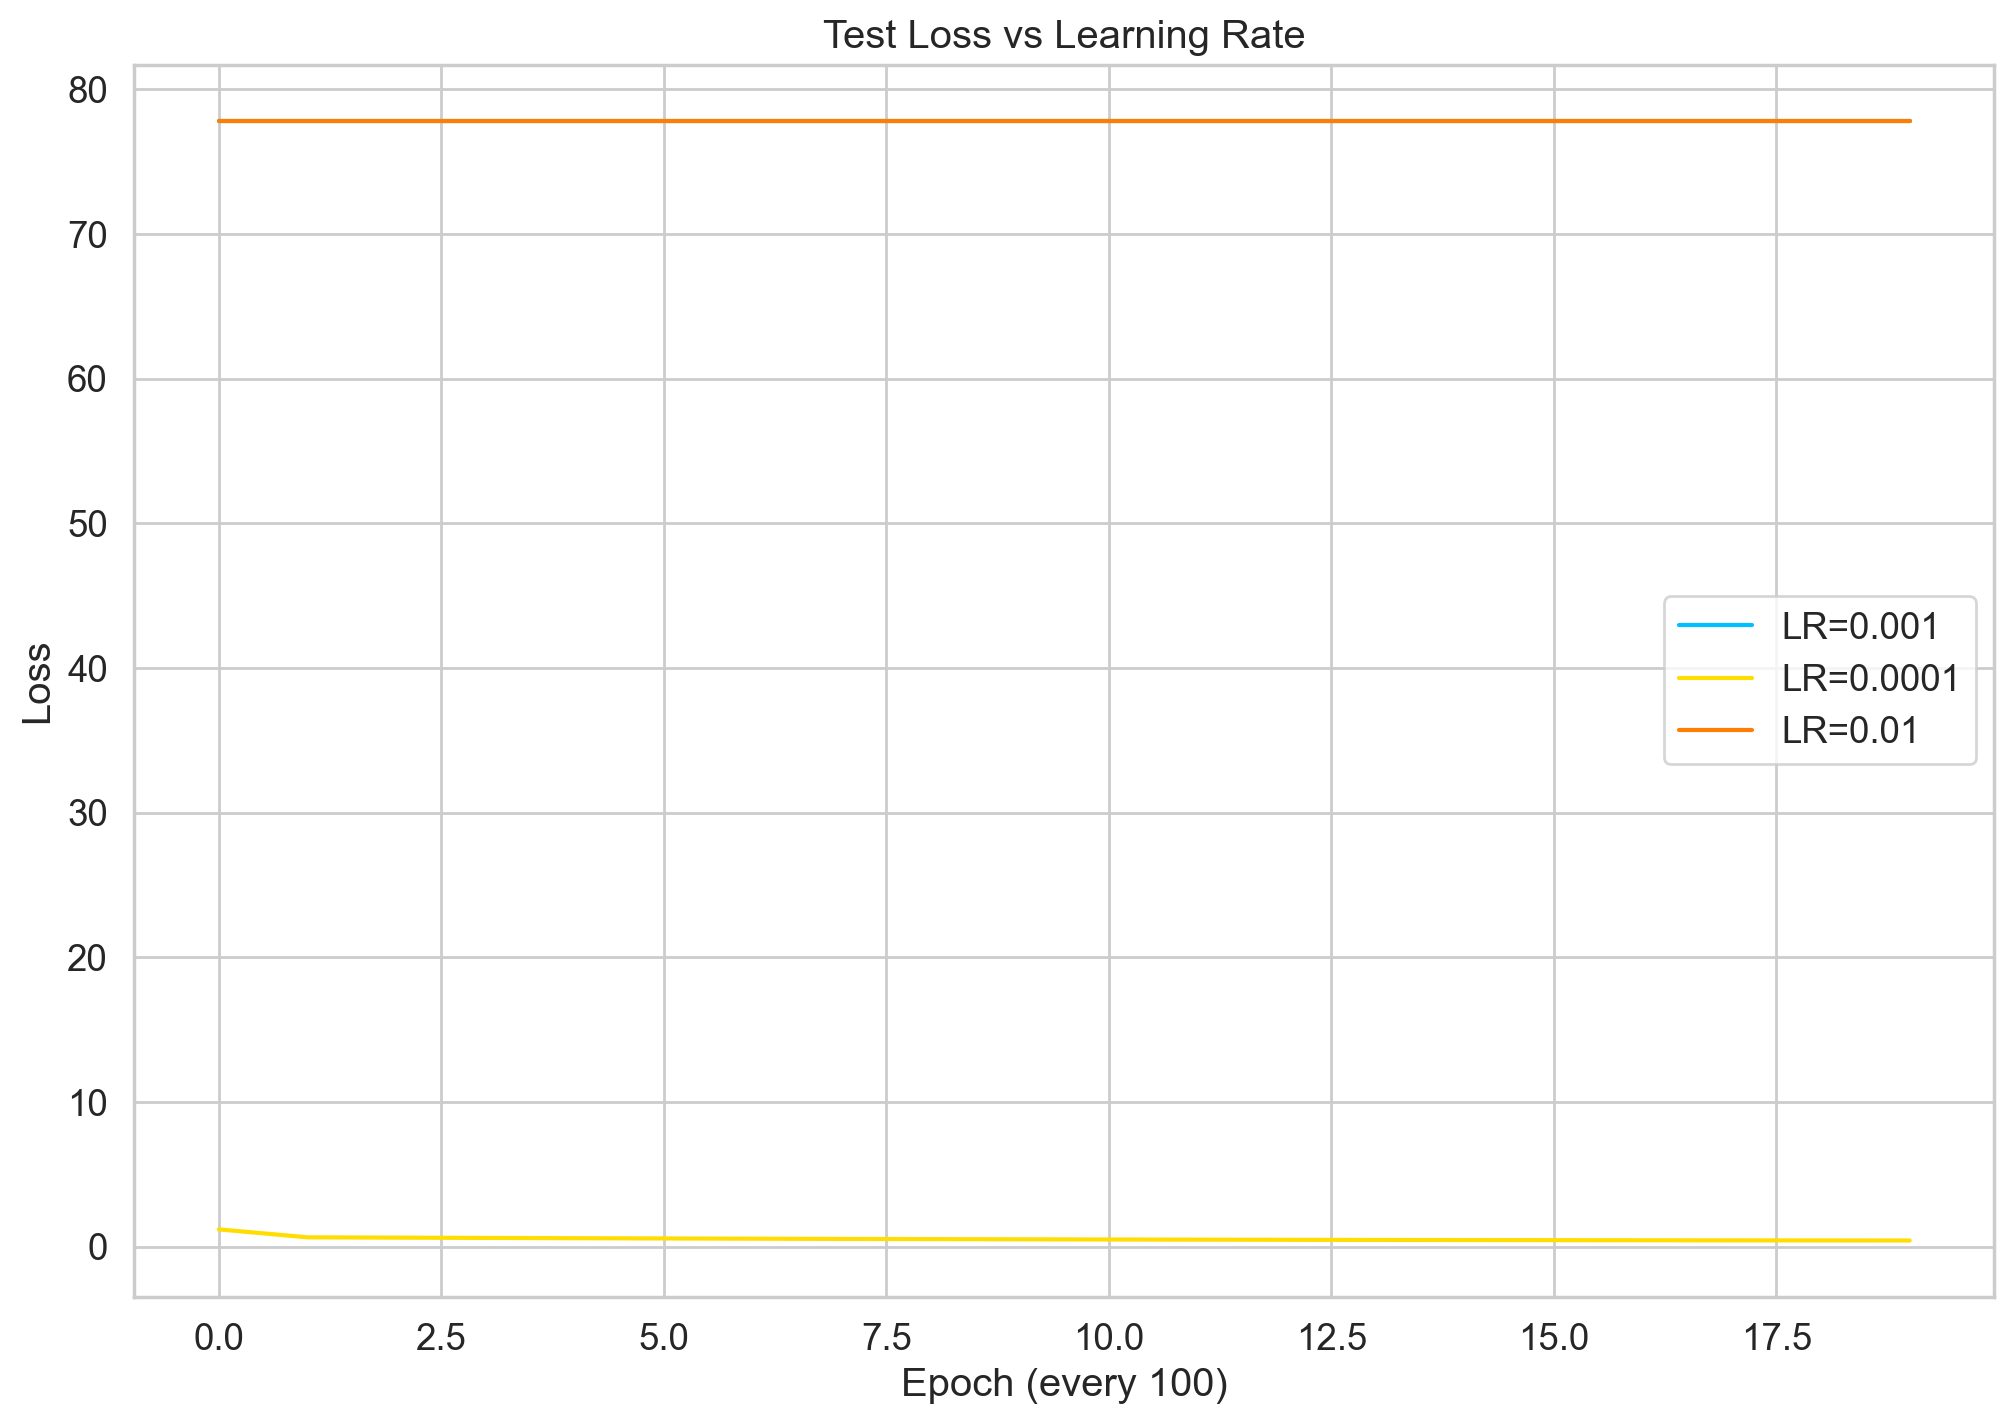

In [54]:
def train_and_evaluate(learning_rates):
    results = {}
    
    for lr in learning_rates:
        net = Net(4).to(device)
        optimizer = optim.Adam(net.parameters(), lr=lr)
        
        train_losses = []
        test_losses = []
        test_accuracies = []
        
        for epoch in range(2000):
            # Обучение
            net.train()
            y_pred_train = net(X_train)
            train_loss = criterion(y_pred_train.squeeze(), y_train)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            if epoch % 100 == 0:
                # Тестирование
                net.eval()
                with torch.no_grad():
                    y_test_pred = net(X_test)
                    test_loss = criterion(y_test_pred.squeeze(), y_test)
                    test_acc = calculate_accuracy(y_test, y_test_pred)

                train_losses.append(train_loss.item())
                test_losses.append(test_loss.item())
                test_accuracies.append(test_acc.item())

                print(f'Learning Rate: {lr:.5f}, Epoch: {epoch}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

        results[lr] = {
            'train_losses': train_losses,
            'test_losses': test_losses,
            'test_accuracies': test_accuracies
        }
    
    return results

learning_rates_to_try= [0.001, 0.0001, 0.01]
results_by_lr=train_and_evaluate(learning_rates_to_try)
 
for lr in results_by_lr.keys():
    plt.plot(results_by_lr[lr]['test_losses'], label=f'LR={lr}')
plt.title('Test Loss vs Learning Rate')
plt.xlabel('Epoch (every 100)')
plt.ylabel('Loss')
plt.legend()
plt.show()

Learning Rate: 0.00100, Epoch: 0, Test Loss: 0.6651, Test Accuracy: 0.7785
Learning Rate: 0.00100, Epoch: 100, Test Loss: 0.6235, Test Accuracy: 0.7785
Learning Rate: 0.00100, Epoch: 200, Test Loss: 0.4877, Test Accuracy: 0.7785
Learning Rate: 0.00100, Epoch: 300, Test Loss: 0.4215, Test Accuracy: 0.7785
Learning Rate: 0.00100, Epoch: 400, Test Loss: 0.4138, Test Accuracy: 0.7785
Learning Rate: 0.00100, Epoch: 500, Test Loss: 0.4106, Test Accuracy: 0.7785
Learning Rate: 0.00100, Epoch: 600, Test Loss: 0.4081, Test Accuracy: 0.7785
Learning Rate: 0.00100, Epoch: 700, Test Loss: 0.4059, Test Accuracy: 0.7785
Learning Rate: 0.00100, Epoch: 800, Test Loss: 0.4039, Test Accuracy: 0.7785
Learning Rate: 0.00100, Epoch: 900, Test Loss: 0.4020, Test Accuracy: 0.7785
Learning Rate: 0.00100, Epoch: 1000, Test Loss: 0.4003, Test Accuracy: 0.7785
Learning Rate: 0.00100, Epoch: 1100, Test Loss: 0.3987, Test Accuracy: 0.7785
Learning Rate: 0.00100, Epoch: 1200, Test Loss: 0.3972, Test Accuracy: 0.841

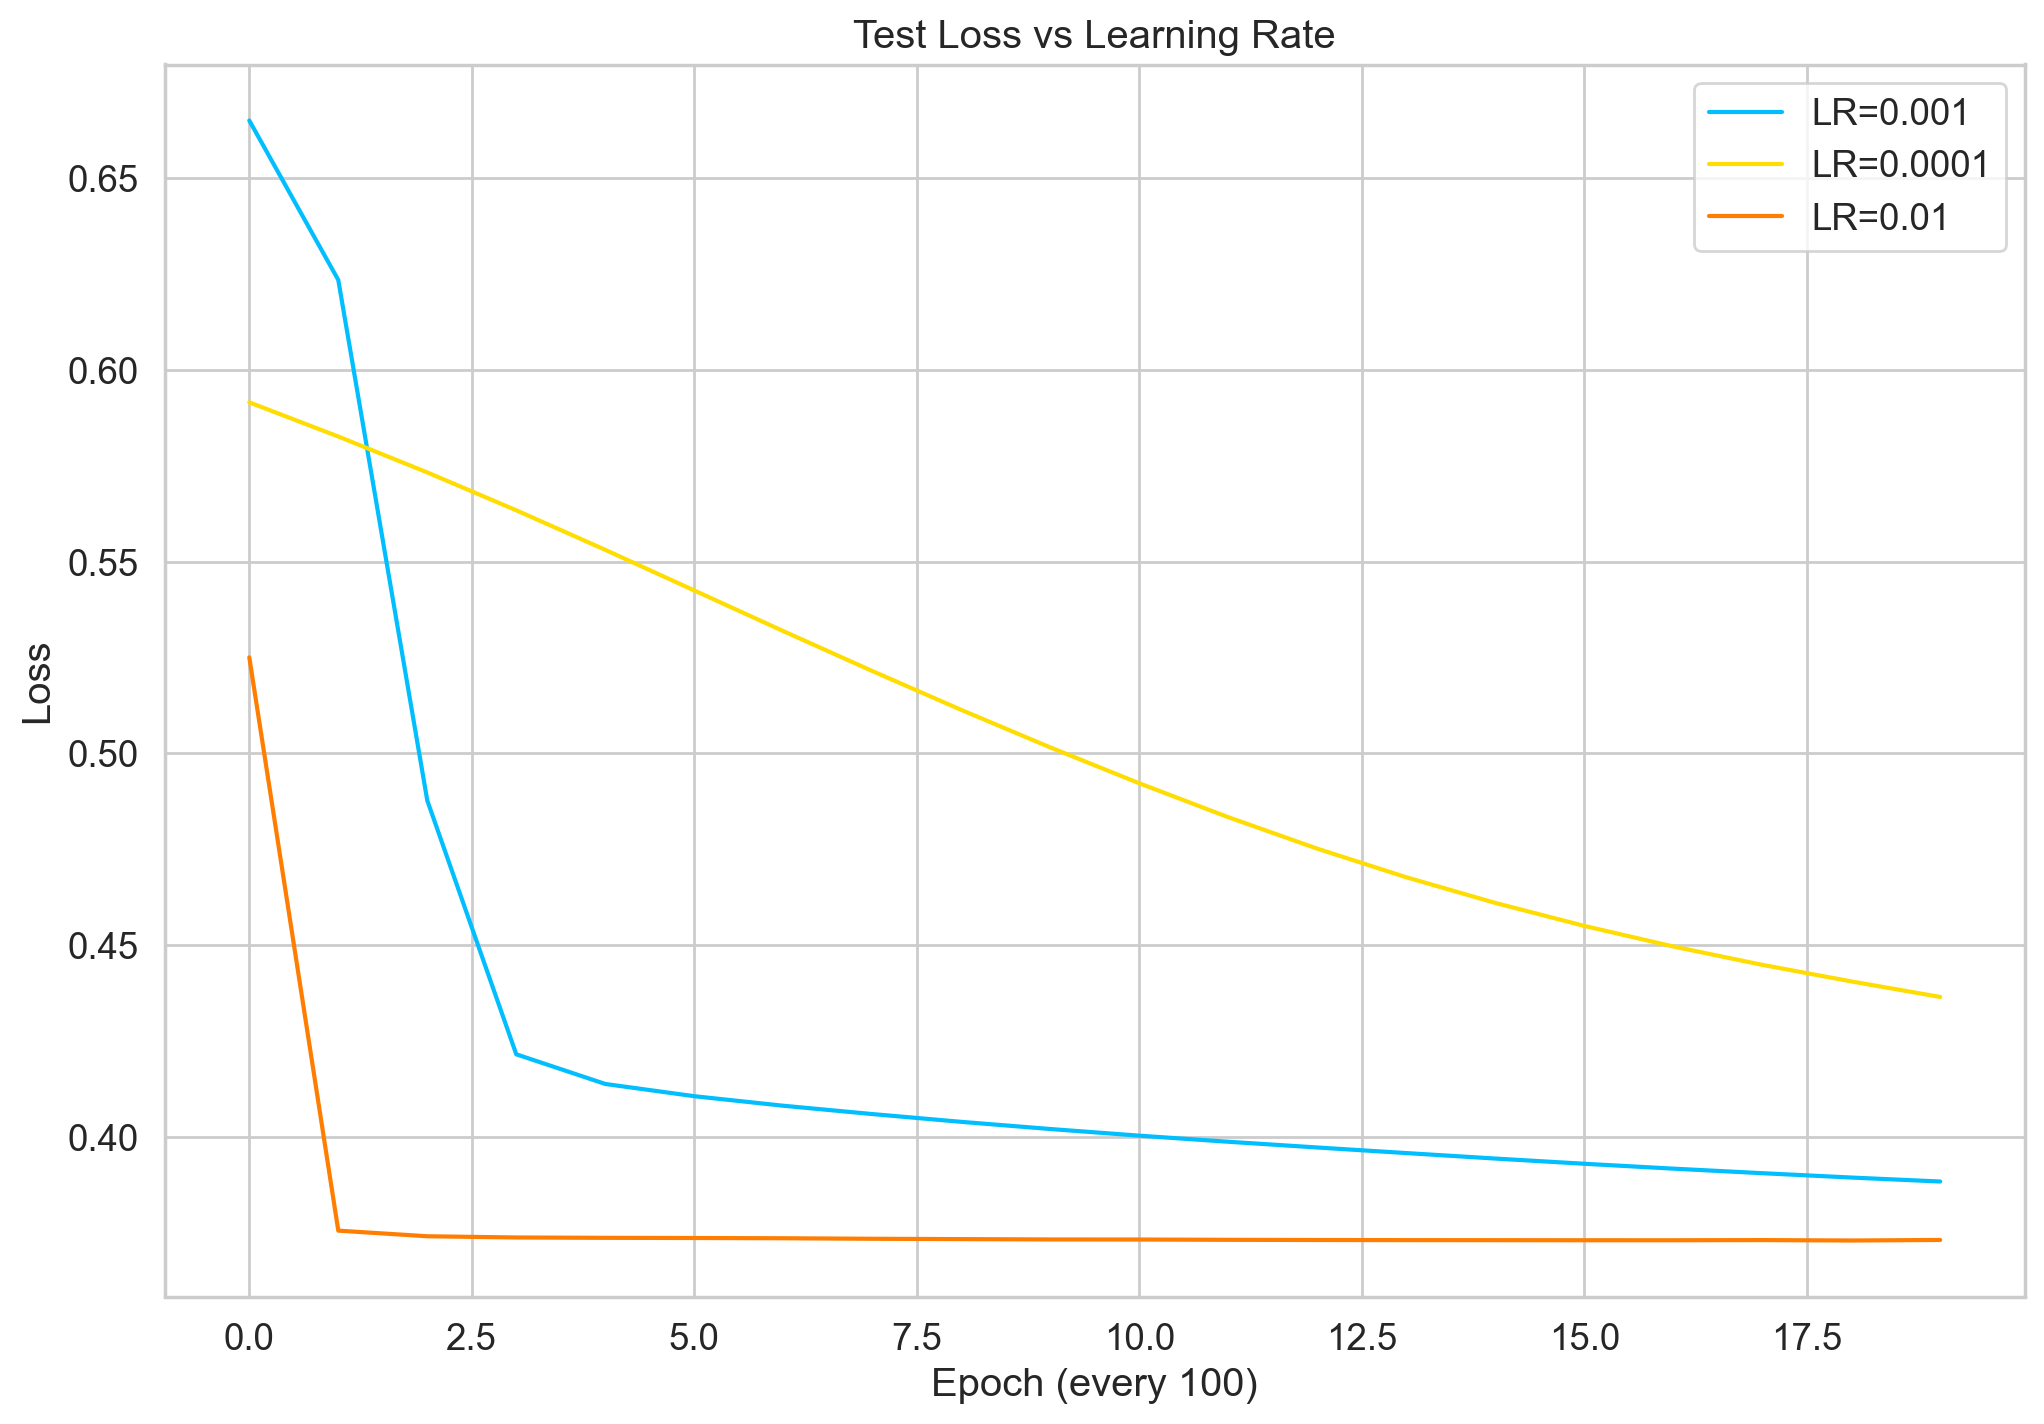

In [55]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=RANDOM_SEED)

X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float()).to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float()).to(device)

learning_rates_to_try= [0.001, 0.0001, 0.01]
results_by_lr=train_and_evaluate(learning_rates_to_try)
 
for lr in results_by_lr.keys():
    plt.plot(results_by_lr[lr]['test_losses'], label=f'LR={lr}')
plt.title('Test Loss vs Learning Rate')
plt.xlabel('Epoch (every 100)')
plt.ylabel('Loss')
plt.legend()
plt.show()

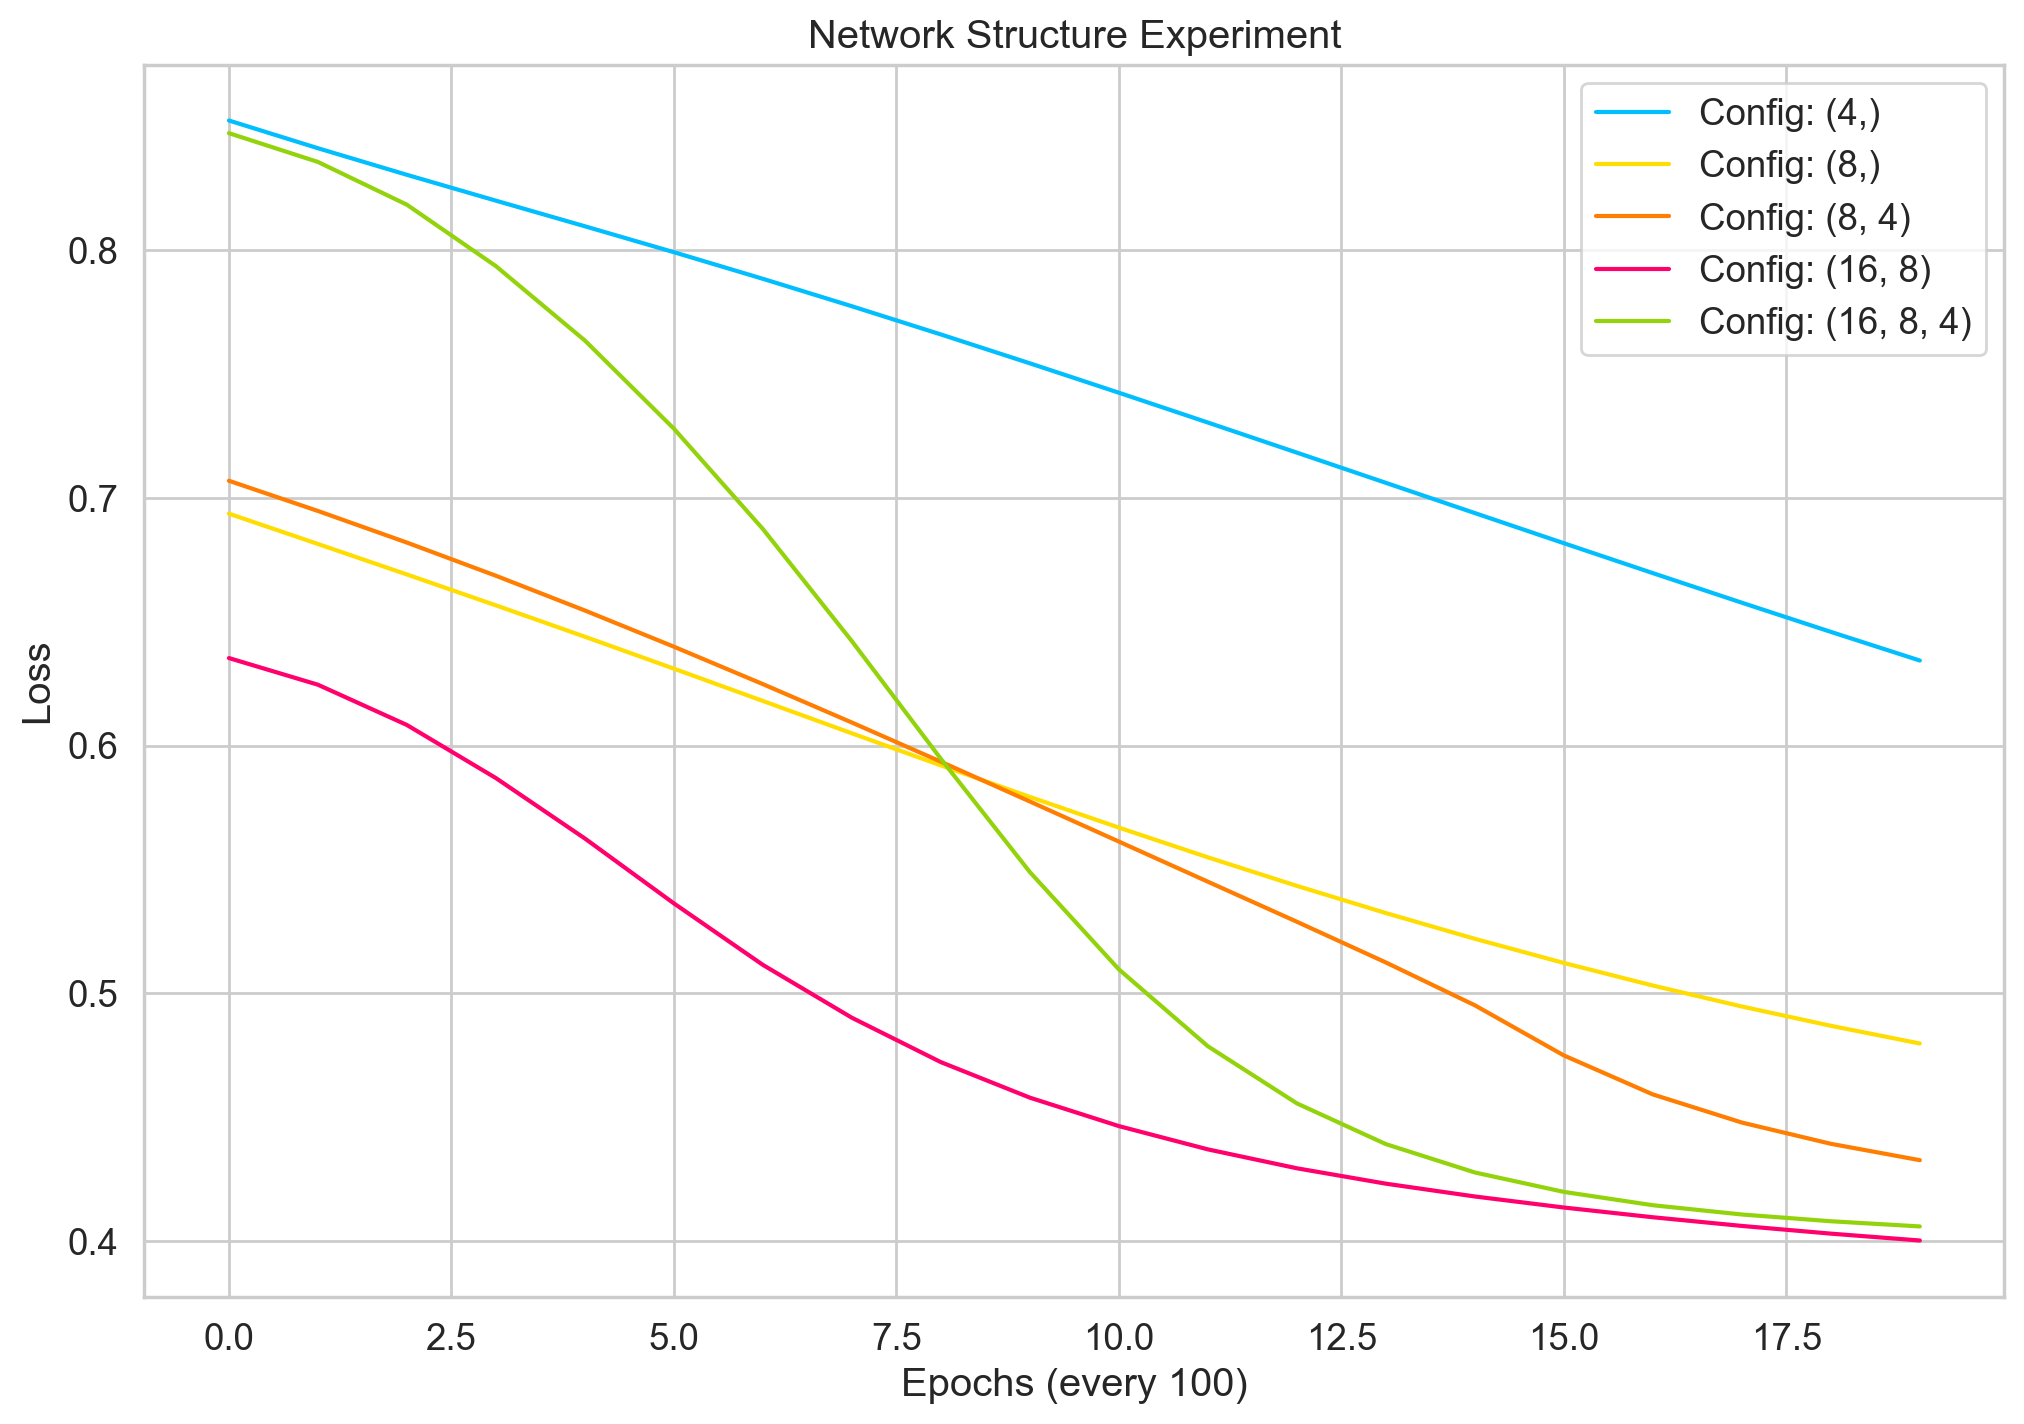

In [56]:
class newNet(nn.Module):
    def __init__(self, layer_sizes):
        super(newNet, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        x = torch.sigmoid(self.layers[-1](x))
        return x


def experiment_network_structure(layers_config):
    results = {}
    for config in layers_config:
        net = newNet([X_train.shape[1]] + config + [1]).to(device)
        optimizer = optim.Adam(net.parameters(), lr=0.0001)
        train_losses = []
        
        for epoch in range(2000):
            net.train()
            y_pred = net(X_train)
            train_loss = criterion(y_pred.squeeze(), y_train)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            
            if epoch % 100 == 0:
                train_losses.append(train_loss.item())
        
        results[tuple(config)] = train_losses
    
    plt.figure(figsize=(12, 8))
    for config, losses in results.items():
        plt.plot(losses, label=f'Config: {config}')
    
    plt.title('Network Structure Experiment')
    plt.xlabel('Epochs (every 100)')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Example usage
layers_configurations = [[4], [8], [8, 4], [16, 8], [16, 8, 4]]
experiment_network_structure(layers_configurations)

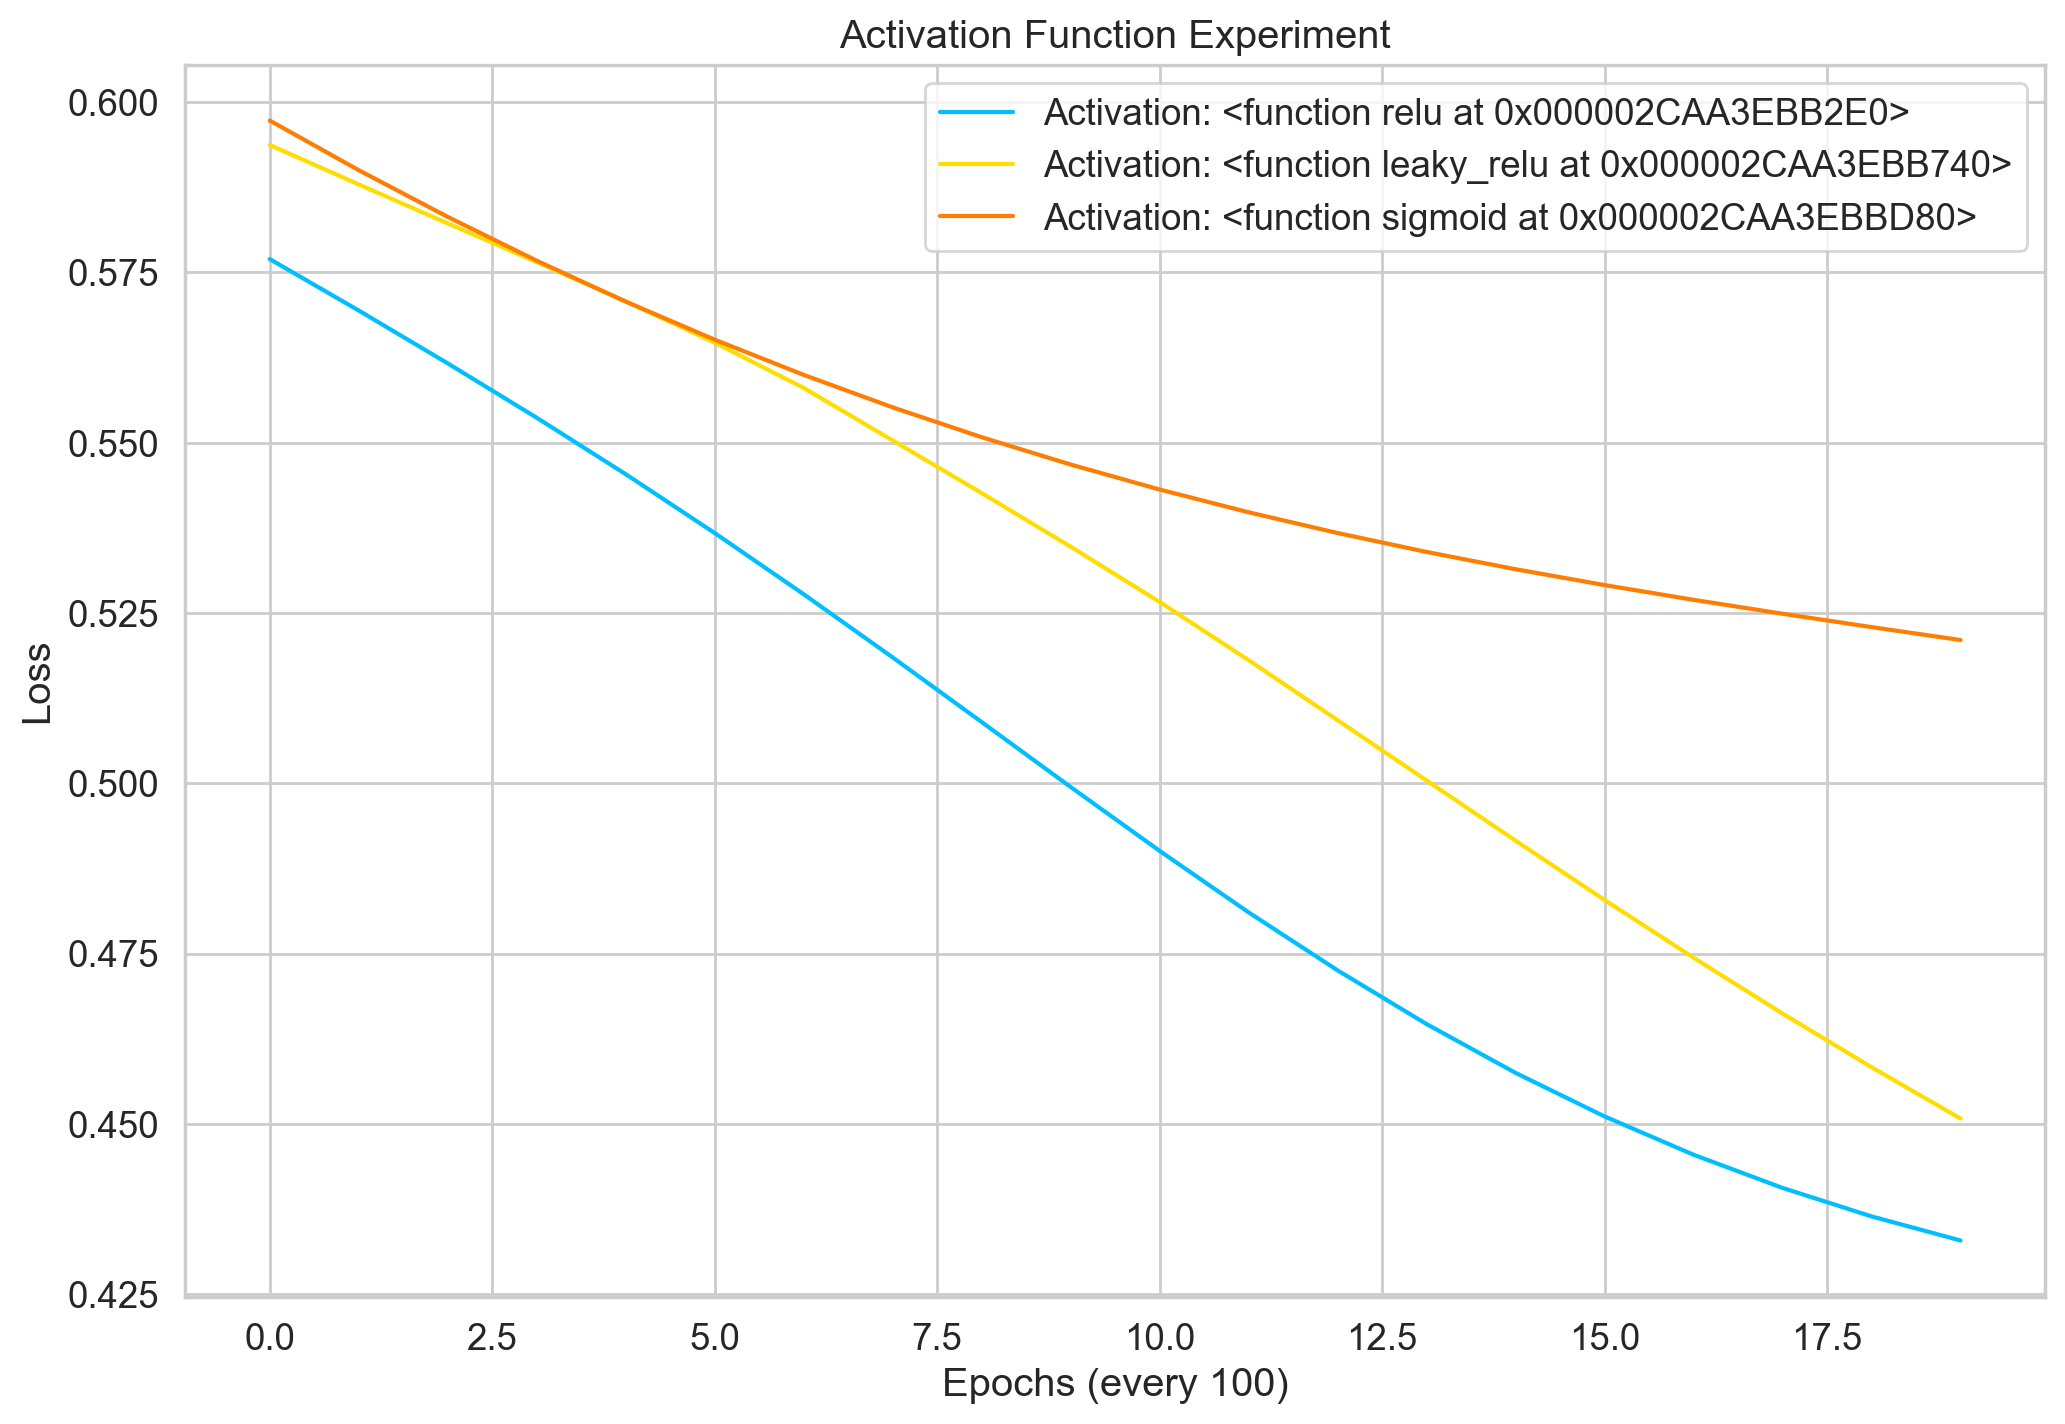

In [57]:
class NetWithActivation(nn.Module):
    def __init__(self, n_features, activation_function=F.relu):
        super(NetWithActivation, self).__init__()
        self.fc1 = nn.Linear(n_features, 8)
        self.fc2 = nn.Linear(8, 4)
        self.fc3 = nn.Linear(4, 1)
        self.activation_function = activation_function

    def forward(self, x):
        x = self.activation_function(self.fc1(x))
        x = self.activation_function(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

def experiment_activation_functions(activations):
    results = {}
    
    for activation in activations:
        net = NetWithActivation(4, activation).to(device)
        optimizer = optim.Adam(net.parameters(), lr=0.0001)
        
        train_losses = []
        
        for epoch in range(2000):
            net.train()
            y_pred = net(X_train)
            train_loss = criterion(y_pred.squeeze(), y_train)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            
            if epoch % 100 == 0:
                train_losses.append(train_loss.item())
        
        results[str(activation)] = train_losses
    
    plt.figure(figsize=(12, 8))
    for activation_name, losses in results.items():
        plt.plot(losses, label=f'Activation: {activation_name}')
    
    plt.title('Activation Function Experiment')
    plt.xlabel('Epochs (every 100)')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

activations_to_test = [F.relu, F.leaky_relu, F.sigmoid]
experiment_activation_functions(activations_to_test)

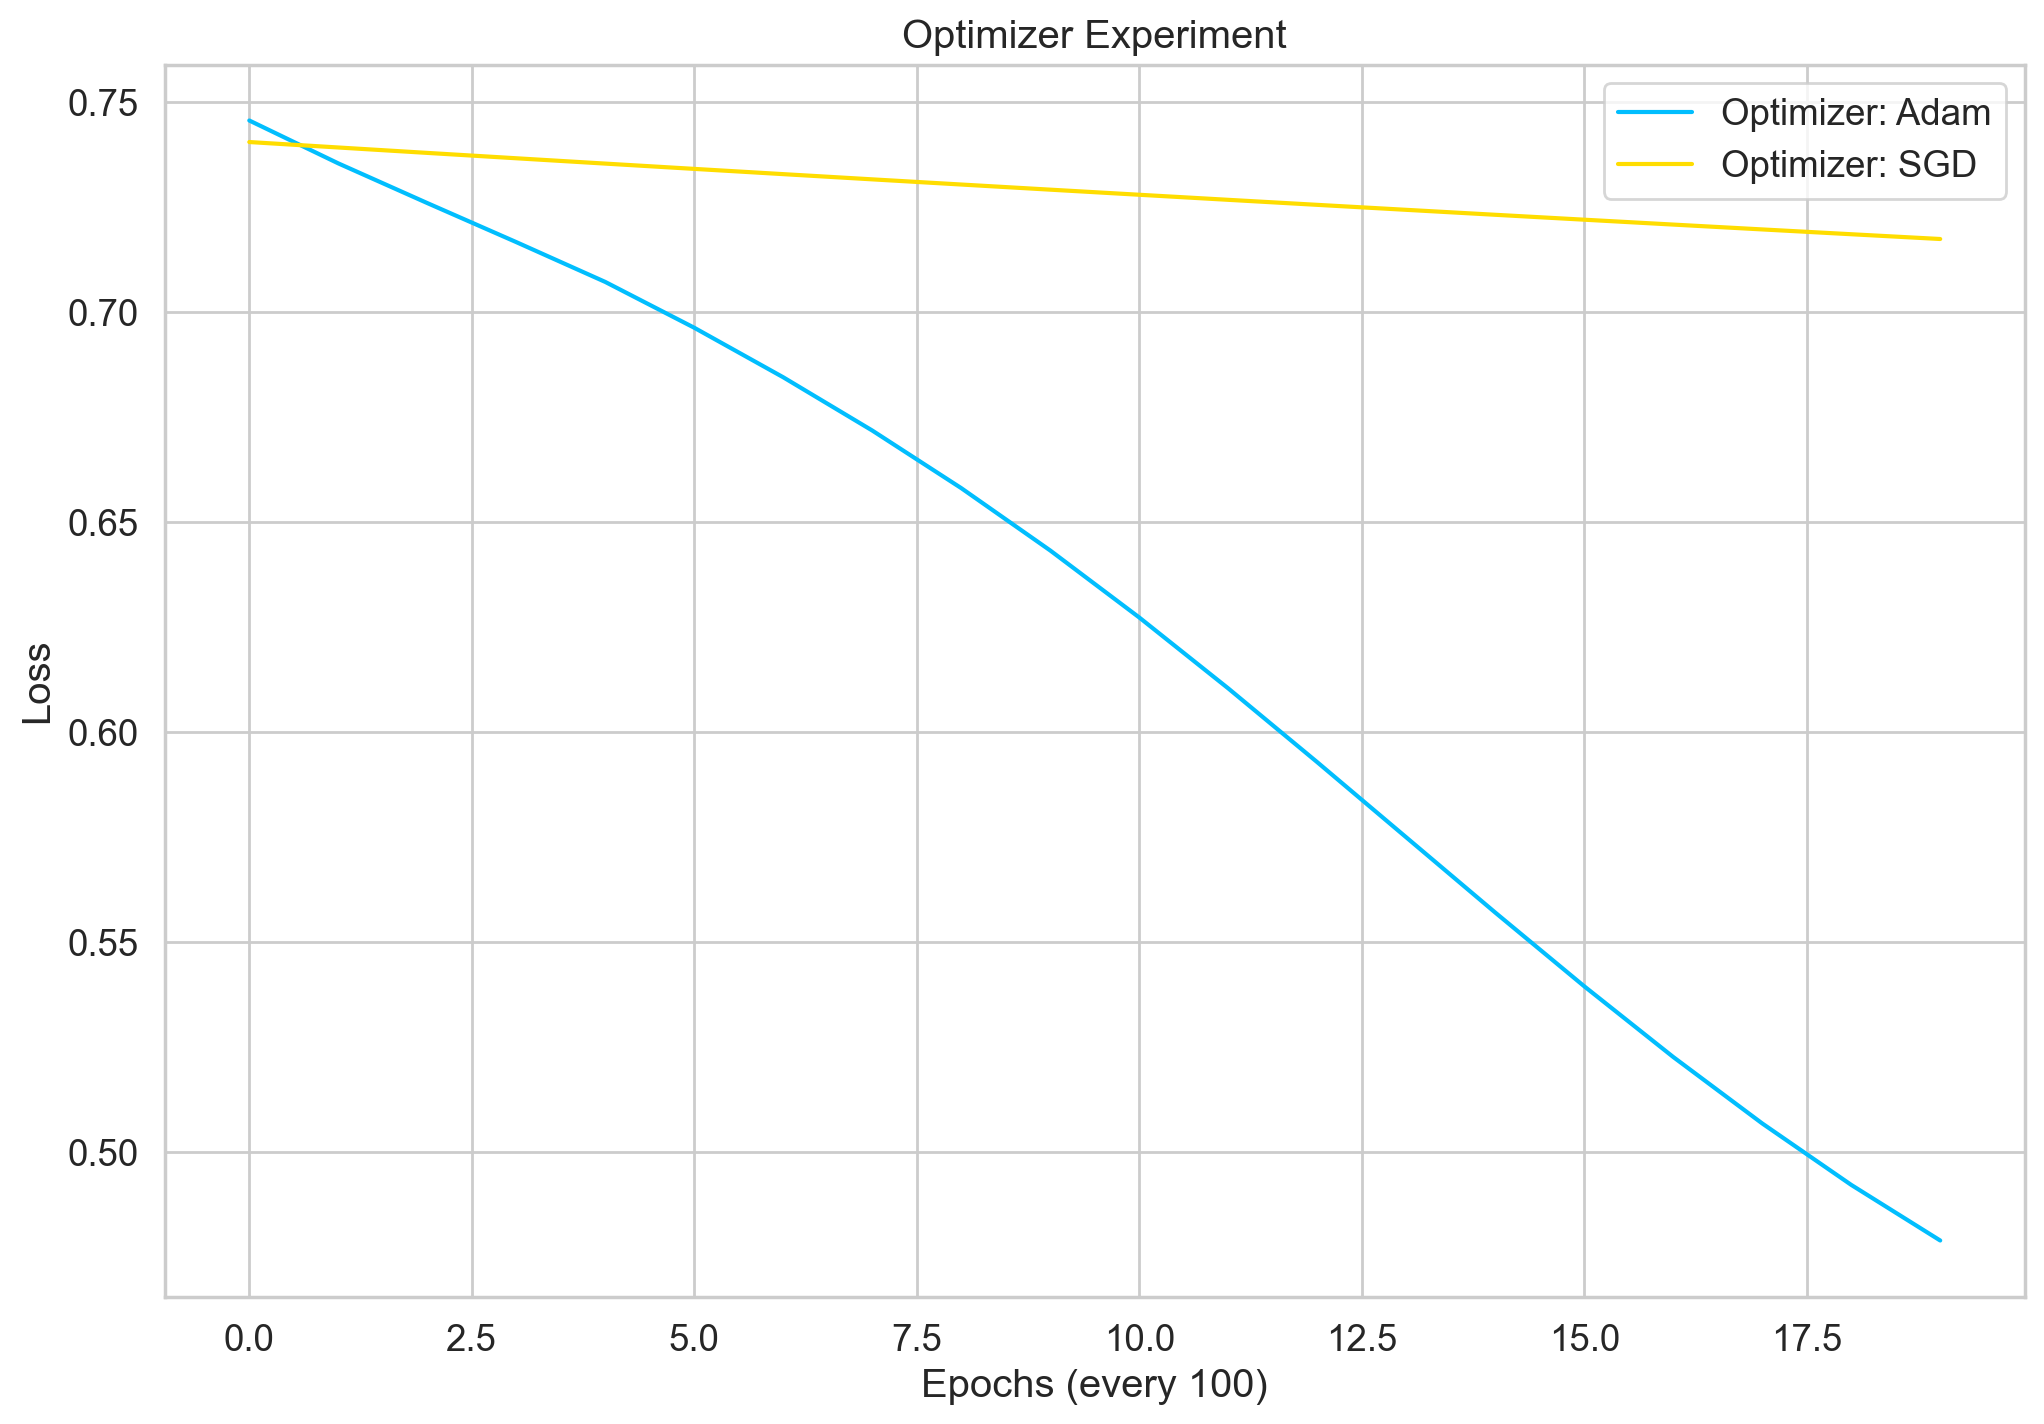

In [58]:
def experiment_optimizers(optimizers):
    results = {}
    
    for opt_name, optimizer_class in optimizers.items():
        net = Net(4).to(device)
        optimizer = optimizer_class(net.parameters(), lr=0.0001)
        
        train_losses = []
        
        for epoch in range(2000):
            net.train()
            y_pred = net(X_train)
            train_loss = criterion(y_pred.squeeze(), y_train)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            
            if epoch % 100 == 0:
                train_losses.append(train_loss.item())
        
        results[opt_name] = train_losses
    
    plt.figure(figsize=(12, 8))
    for opt_name, losses in results.items():
        plt.plot(losses, label=f'Optimizer: {opt_name}')
    
    plt.title('Optimizer Experiment')
    plt.xlabel('Epochs (every 100)')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

optimizers_to_test = {
    'Adam': optim.Adam,
    'SGD': optim.SGD,
}
experiment_optimizers(optimizers_to_test)

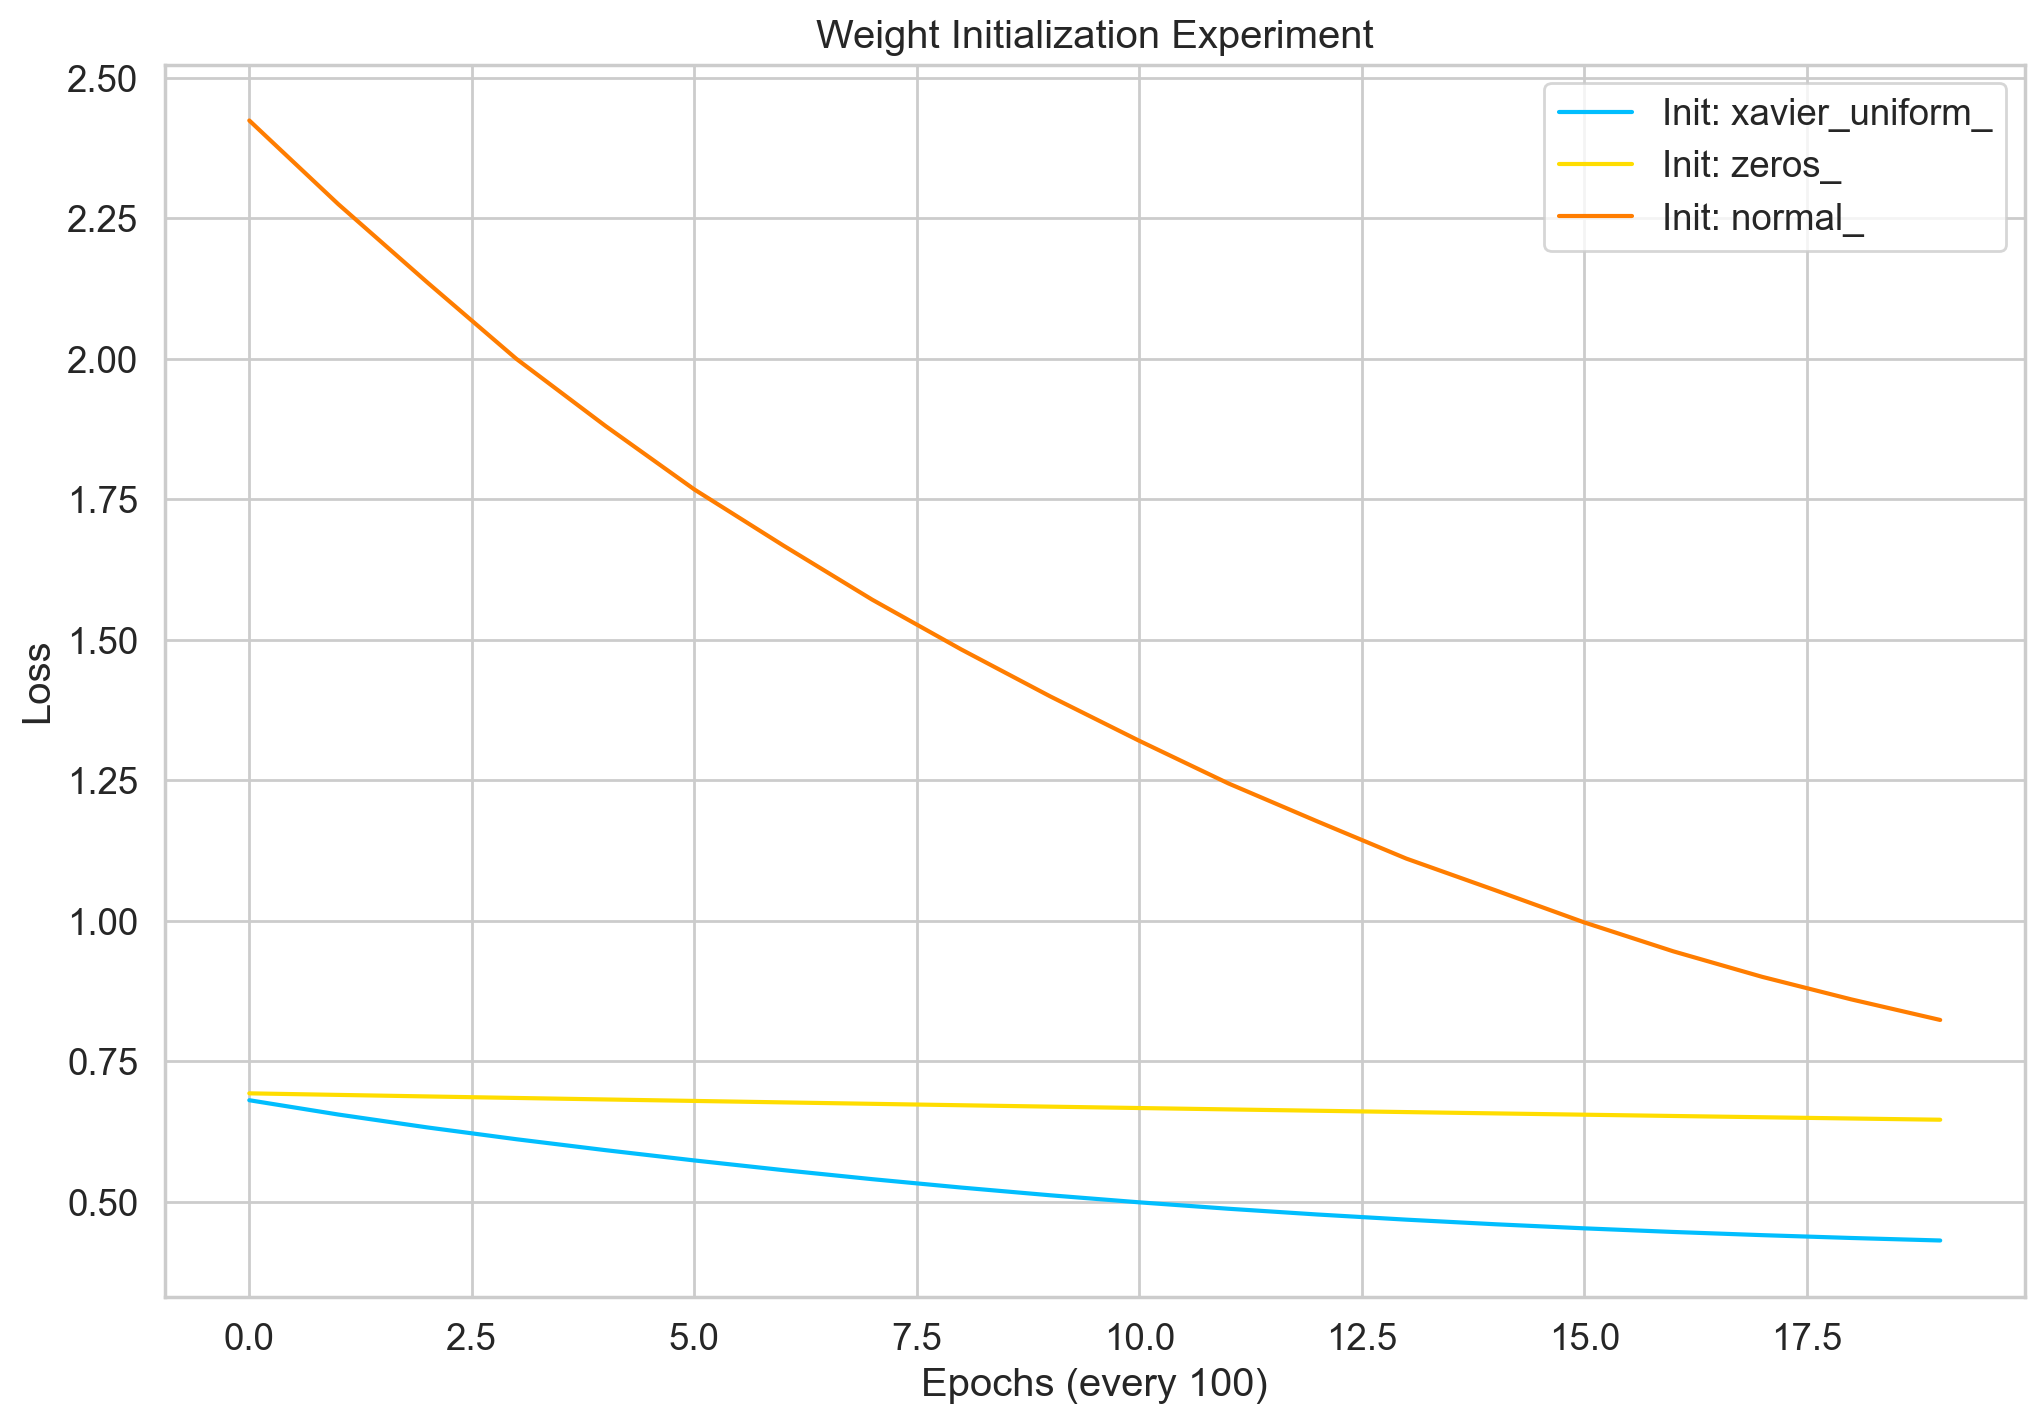

In [59]:
def experiment_weight_initialization(initializations):
    results = {}
    
    for init_func in initializations:
        net = newNet([X_train.shape[1], 8, 4, 1]).to(device) 
        
        
        for layer in net.layers:
            if isinstance(layer, nn.Linear):
                init_func(layer.weight)
                nn.init.zeros_(layer.bias)

        optimizer = optim.Adam(net.parameters(), lr=0.0001)

        train_losses = []
        
        for epoch in range(2000):
            net.train()
            y_pred = net(X_train)
            train_loss = criterion(y_pred.squeeze(), y_train)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            if epoch % 100 == 0:
                train_losses.append(train_loss.item())

        results[init_func.__name__] = train_losses
    

    plt.figure(figsize=(12, 8))
    for init_name, losses in results.items():
        plt.plot(losses, label=f'Init: {init_name}')
    
    plt.title('Weight Initialization Experiment')
    plt.xlabel('Epochs (every 100)')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


initializations_to_test = [
    torch.nn.init.xavier_uniform_,
    torch.nn.init.zeros_,
    torch.nn.init.normal_,
]
experiment_weight_initialization(initializations_to_test)